In [140]:
import numpy as np
from scipy.stats import gmean

In [141]:
def check_independence_assumption(ground_truth : np.ndarray, single_site_frequencies: np.array, sequence_effects : np.ndarray, frequencies : np.ndarray) -> tuple:
    
    # get number_states and sequence length
    number_states, sequence_length = ground_truth.shape

    # compute the geometric mean of the sequence effects
    gmean_sequence_effects = gmean(sequence_effects, weights=frequencies)

    # compute the products of the geometric means of the single site effects (columns are positions, rows are states)
    gmean_single_site_effects = np.prod(gmean(ground_truth, axis=1, weights=single_site_frequencies), axis=0)

    # check if the geometric mean of the sequence effects is equal to the product of the geometric means of the single site effects
    print("gmean sequence effects: ", np.round(gmean_sequence_effects, 5))
    print("product of gmean single site effects: ", np.round(gmean_single_site_effects, 5))
    print("gmean sequence effects is equal to product of gmean single site effects: ", np.isclose(gmean_sequence_effects, gmean_single_site_effects))

    return gmean_sequence_effects, gmean_single_site_effects

In [142]:
number_states = 4
sequence_length = 5
p_effect = 0.1
p_state_change = 1/4

In [143]:
def generate_ground_truth(number_states : int, sequence_length : int, p_effect : float, mean : float) -> np.ndarray:
    # default state has value 1
    default_state = np.ones(sequence_length)
    # mutant states are drawn from a log-normal distribution
    mutant_states = np.round(np.random.lognormal(mean=mean, sigma=1, size=(number_states-1, sequence_length)),2)
    # set mutant states to 1 with probability 1 - p_effect
    mutant_states = np.where(np.random.rand(*mutant_states.shape) < 1-p_effect, 1, mutant_states)

    return np.row_stack((default_state, mutant_states))

In [144]:
def generate_sequences(ground_truth : np.ndarray, p_state_change : float, random : bool = False, pruning : bool = False) -> np.ndarray:

    # get number_states and sequence length
    number_states, sequence_length = ground_truth.shape

    # create every possible sequence
    sequences = np.array(np.meshgrid(*[np.arange(number_states)]*sequence_length)).T.reshape(-1, sequence_length)

    if not random: 
        # calculate the probability of each sequence as p_state_change**number of state changes * (1-p_state_change)**(sequence_length - number of state changes)
        state_changes = np.sum(sequences != np.zeros(sequence_length), axis=1)
        frequencies = (p_state_change/(number_states-1))**state_changes * (1-p_state_change)**(sequence_length - state_changes)

    if random:
        # generate a random frequency for each sequence
        frequencies = np.random.rand(sequences.shape[0])
        # normalize frequencies
        frequencies = frequencies / np.sum(frequencies)

    if pruning:
        # set frequency < 0.00001 to 0
        frequencies = np.where(frequencies < 0.001, 0, frequencies)
        #normalize frequencies
        frequencies = frequencies / np.sum(frequencies)


    # compute effect of each unique sequence
    # effect of a sequence is the product of the effects of the states per position
    sequence_effects = np.array([np.prod([ground_truth[int(sequences[i,j]), j] for j in range(sequence_length)]) for i in range(sequences.shape[0])])

    # print("sequences: ", sequences)
    print("frequencies: ", frequencies)
    print("sequence_effects: ", sequence_effects)

    return sequences, frequencies, sequence_effects

In [145]:
def compute_single_site_frequencies(sequences : np.ndarray, frequencies : np.ndarray, number_states : int, sequence_length : int) -> np.ndarray:
    # create a matrix of frequencies of each state at each position
    single_site_frequencies = np.zeros((number_states, sequence_length))
    for i in range(number_states):
        for j in range(sequence_length):
            # get the row indices of the unique sequences that have state i at position j
            row_indices = np.where(sequences[:,j] == i)[0]
            # sum the counts of these sequences
            single_site_frequencies[i,j] = np.sum(frequencies[row_indices])

    return single_site_frequencies

In [146]:
def assumption_test(number_states : int, sequence_length : int, p_effect : float, p_state_change : float, random : bool = False, pruning : bool = False, mean: float = 0) -> None:
    # generate ground truth
    ground_truth = generate_ground_truth(number_states, sequence_length, p_effect, mean)

    # generate sequences
    sequences, frequencies, sequence_effects = generate_sequences(ground_truth, p_state_change, random, pruning)

    # compute single site frequencies
    single_site_frequencies = compute_single_site_frequencies(sequences, frequencies, number_states, sequence_length)

    # check independence assumption
    gmean_sequence_effects, gmean_single_site_effects = check_independence_assumption(ground_truth, single_site_frequencies, sequence_effects, frequencies)

    return np.log(gmean_sequence_effects), np.log(gmean_single_site_effects)

In [147]:
# do the assumption test for different scenarios with n=100 simulations
n = 100
number_states = 4
sequence_length = 5
p_effect = 0.7
p_state_change = 1/4

det = []
random = []
pruning = []
random_pruning = []

for i in range(n):

    gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, sequence_length, p_effect, p_state_change)
    det.append((gmean_sequence_effects, gmean_single_site_effects))
    
    gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, sequence_length, p_effect, p_state_change, random=True)
    random.append((gmean_sequence_effects, gmean_single_site_effects))
    
    gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, sequence_length, p_effect, p_state_change, pruning=True)
    pruning.append((gmean_sequence_effects, gmean_single_site_effects))

frequencies:  [2.37304688e-01 2.63671875e-02 2.63671875e-02 ... 4.01877572e-06
 4.01877572e-06 4.01877572e-06]
sequence_effects:  [1.         0.66       2.26       ... 2.43033945 8.32207145 3.6823325 ]
gmean sequence effects:  1.00234
product of gmean single site effects:  1.00563
gmean sequence effects is equal to product of gmean single site effects:  False
frequencies:  [0.00193923 0.00155628 0.00161685 ... 0.00055994 0.00104068 0.00134288]
sequence_effects:  [ 1.          1.68        1.         ... 49.11761756 29.23667712
 23.97407524]
gmean sequence effects:  2.0478
product of gmean single site effects:  1.77659
gmean sequence effects is equal to product of gmean single site effects:  False
frequencies:  [0.26470588 0.02941176 0.02941176 ... 0.         0.         0.        ]
sequence_effects:  [ 1.          0.8         6.47       ...  1.5555072  12.58016448
  1.944384  ]
gmean sequence effects:  1.26145
product of gmean single site effects:  1.96772
gmean sequence effects is equal

In [148]:
#get differences between gmean_sequence_effects and gmean_single_site_effects
det_diff = [np.abs(det[i][0] - det[i][1]) for i in range(n)]
random_diff = [np.abs(random[i][0] - random[i][1]) for i in range(n)]
pruning_diff = [np.abs(pruning[i][0] - pruning[i][1]) for i in range(n)]

print("deterministic: ", det_diff)
print("random: ", random_diff)
print("pruning: ", pruning_diff)

deterministic:  [0.0032750392491978013, 0.36141204467066057, 0.7332063671070976, 1.024786231749614, 0.5615225921709888, 0.9563723673393061, 0.51856442782312, 0.8038296294706766, 0.9290651048717664, 0.006350706587315501, 0.04446095464612071, 0.1626131490521311, 0.2872258298845335, 0.1664587286530046, 0.7341164386430277, 0.40046926722229864, 0.19865997778071942, 0.023496617020909945, 0.6757504527261262, 0.5010316223318605, 0.4218124971951323, 0.00637304014822828, 0.6868458440303156, 0.3017464555418031, 0.18528611362614114, 0.22963890484634308, 0.040110275544167136, 0.4158622662539667, 0.1622134677359681, 0.0071916639820899875, 0.6639516634148906, 0.9699567454949942, 0.8186067533125921, 0.44326907126962267, 0.10567606970213687, 0.42253850107253627, 0.09116582142435077, 0.7871996622978309, 0.6206952314801982, 0.3224110467583553, 0.02192004865268052, 0.451232525195996, 0.610159412693666, 0.3169300505018521, 0.325104845352575, 0.008828739586137708, 0.2419400931805507, 0.06664821034539553, 0.

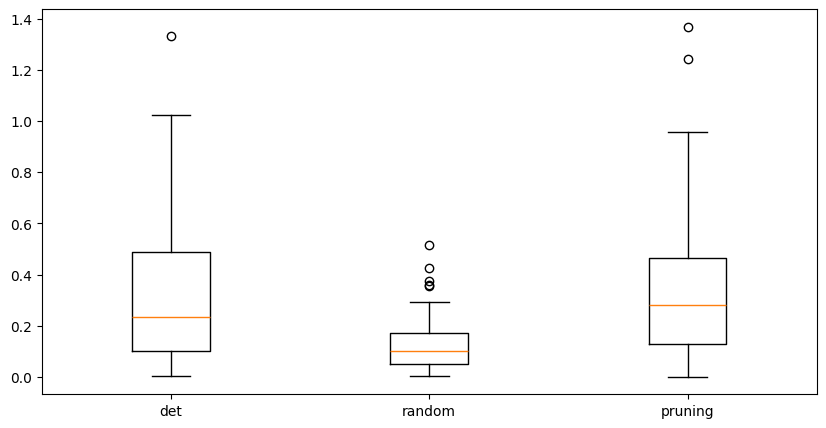

In [149]:
# make boxplot
import matplotlib.pyplot as plt

data = [det_diff, random_diff, pruning_diff]
fig = plt.figure(figsize =(10, 5))
plt.boxplot(data)
# labels
plt.xticks([1, 2, 3], ['det', 'random', 'pruning'])
plt.show()

In [150]:
# do the assumption test for different scenarios with n=100 simulations
n = 100
number_states = 4
sequence_length = 5
p_effect = 0.7
p_state_change = 1/4

mean_0 = []
mean_1 = []

for i in range(n):
    
        gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, sequence_length, p_effect, p_state_change, mean=0)
        mean_0.append((gmean_sequence_effects, gmean_single_site_effects))
        
        gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, sequence_length, p_effect, p_state_change, mean=1)
        mean_1.append((gmean_sequence_effects, gmean_single_site_effects))

#get differences between gmean_sequence_effects and gmean_single_site_effects
mean_0_diff = [np.abs(mean_0[i][0] - mean_0[i][1]) for i in range(n)]
mean_1_diff = [np.abs(mean_1[i][0] - mean_1[i][1]) for i in range(n)]

frequencies:  [2.37304688e-01 2.63671875e-02 2.63671875e-02 ... 4.01877572e-06
 4.01877572e-06 4.01877572e-06]
sequence_effects:  [ 1.       1.07     1.16    ... 10.79844 11.70672  2.22024]
gmean sequence effects:  0.99413
product of gmean single site effects:  0.98597
gmean sequence effects is equal to product of gmean single site effects:  False
frequencies:  [2.37304688e-01 2.63671875e-02 2.63671875e-02 ... 4.01877572e-06
 4.01877572e-06 4.01877572e-06]
sequence_effects:  [  1.           1.           0.86       ...  39.927017    34.33723462
 337.78256382]
gmean sequence effects:  2.54535
product of gmean single site effects:  9.41439
gmean sequence effects is equal to product of gmean single site effects:  False
frequencies:  [2.37304688e-01 2.63671875e-02 2.63671875e-02 ... 4.01877572e-06
 4.01877572e-06 4.01877572e-06]
sequence_effects:  [1.       1.13     0.58     ... 1.185822 0.608652 1.0494  ]
gmean sequence effects:  1.3023
product of gmean single site effects:  1.885
gmean se

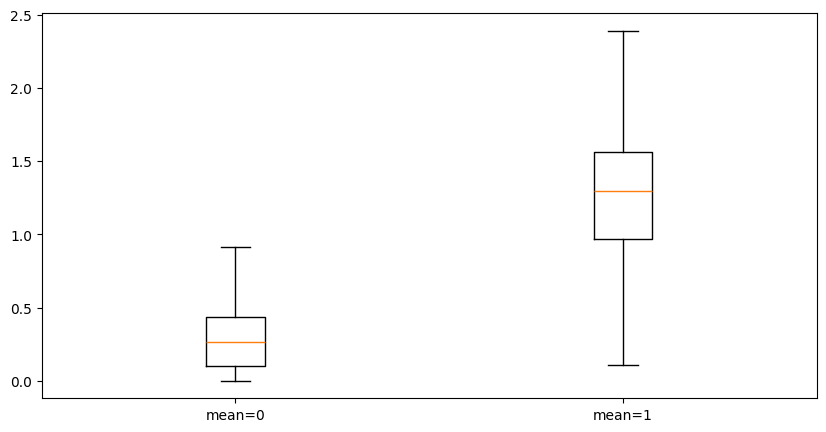

In [151]:
# make boxplot
data = [mean_0_diff, mean_1_diff]
fig = plt.figure(figsize =(10, 5))
plt.boxplot(data)
# labels
plt.xticks([1, 2], ['mean=0', 'mean=1'])
plt.show()

frequencies:  [2.37304688e-01 2.63671875e-02 2.63671875e-02 ... 4.01877572e-06
 4.01877572e-06 4.01877572e-06]
sequence_effects:  [1.         0.31       1.         ... 0.03442364 0.111044   0.16434512]
gmean sequence effects:  0.87617
product of gmean single site effects:  0.72814
gmean sequence effects is equal to product of gmean single site effects:  False
frequencies:  [5.63135147e-02 6.25705719e-03 6.25705719e-03 ... 1.61505583e-11
 1.61505583e-11 1.61505583e-11]
sequence_effects:  [1.        1.        0.6       ... 0.0820435 0.0492261 0.0820435]
gmean sequence effects:  1.00181
product of gmean single site effects:  1.00217
gmean sequence effects is equal to product of gmean single site effects:  False
frequencies:  [2.37304688e-01 2.63671875e-02 2.63671875e-02 ... 4.01877572e-06
 4.01877572e-06 4.01877572e-06]
sequence_effects:  [1.         2.16       1.4        ... 9.79812288 6.3506352  4.536168  ]
gmean sequence effects:  2.10898
product of gmean single site effects:  5.99482


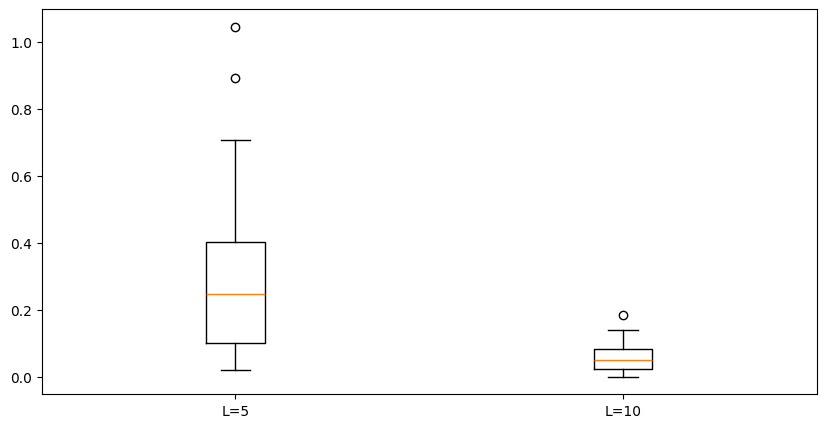

In [152]:
# do the assumption test for L = 5 and L = 10
n = 100
number_states = 4
sequence_length = 5
p_effect = 0.7
p_state_change = 1/4

L_5 = []
L_10 = []

for i in range(n):
        
            gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, 5, p_effect, p_state_change)
            L_5.append((gmean_sequence_effects, gmean_single_site_effects))
            
            gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, 10, p_effect, p_state_change)
            L_10.append((gmean_sequence_effects, gmean_single_site_effects))

#get differences between gmean_sequence_effects and gmean_single_site_effects

L_5_diff = [np.abs(L_5[i][0] - L_5[i][1]) for i in range(n)]
L_10_diff = [np.abs(L_10[i][0] - L_10[i][1]) for i in range(n)]

# make boxplot
data = [L_5_diff, L_10_diff]
fig = plt.figure(figsize =(10, 5))
plt.boxplot(data)
# labels
plt.xticks([1, 2], ['L=5', 'L=10'])
plt.show()